В этой статье мы разберем способы обращения операции свертки на практике с использованием библиотеки TensorFlow.

На исследование этого вопроса меня натолкнула статья [Visualizing and Understanding Convolutional Networks]($Visualizing and Understanding Convolutional Networks$) (M. Zeiler, R. Fergus, 2013). В ней авторы используют транспонированную свертку с теми же весами, чтобы восстановить входные данные сверточного слоя по выходным данным. Возник вопрос: почему применяя транспонированную свертку мы надеемся восстановить входные данные? Чтение предыдущих статей по этой теме (обзоры на них: [1]($Deconvolutional Networks$), [2]($Adaptive Deconvolutional Networks for Mid and High Level Feature Learning$)) ответа на вопрос не дало. Это натолкнуло меня на то, чтобы провести ряд собственных экспериментов.

Мы сравним (в теории и на практике) три способа обращения операции свертки:
1. Аналитическое решение с помощью псевдообратной матрицы
2. Решение с помощью методов оптимизации (Adam и L-BFGS)
3. Транспонированная свертка

### Свертка как матричное умножение

Мы будем рассматривать дискретную свертку с несколькими фильтрами и входными каналами, которая используется в сверточных нейронных сетях. Функцию активации и прибавление bias'а мы не рассматриваем, так как они применяются поэлементно, и задача их обращения либо тривиальна, либо не имеет решения. Подробно про операцию свертки можно почитать в статье [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285), анимированные изображения можно найти на [Github](https://github.com/vdumoulin/conv_arithmetic).

Свертка - это линейное отображение, то есть элементы выходного массива линейно зависят от элементов входного массива, а ноль отображается в ноль. Если мы зафиксируем размер входного массива, то мы можем "вытянуть в векторы" входной и выходной массивы. Для иллюстрации, в numpy это делается операцией `array.reshape(-1)` для одного  изображения или `array.reshape(len(array), -1)` для батча. Любое линейное отображение можно представить в виде умножения на матрицу (справа или слева, в зависимости от того, используем мы вектор-строку или вектор-столбец).

Это означает, что *свертка с фиксированным размером входного изображения может быть представлена как умножение на матрицу*. Большая часть элементов этой матрицы по определению будут нулевыми, поскольку элемент выходного массива связан не со всеми элементами входного массива, а лишь с теми, которые находятся в рамках скользящего окна. Кроме того некоторые пары элементов этой матрицы по определению будут равны, так как мы используем одни и те же фильтры в каждой позиции скользящего окна.

*Примечание: если в каждой позиции скользящего окна мы используем разные фильтры, то такая операция в нейронной сети называется Locally-Connected layer и была описана в [данной статье]($Emergence of Complex-Like Cells in a Temporal Product Network with Local Receptive Fields$).*

### Задача обращения операции свертки

Задача обращения свертки является обратной задачей: мы хотим восстановить $x$, зная $f(x)$. Поскольку операция свертки линейна, то мы имеем дело с [линейной обратной задачей](https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%B0%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0#%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%B0%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0).

#### Корректность задачи

Если решение обратной задачи существует и единственно (а также непрерывно зависит от исходных данных, что в случае свертки всегда верно), то такая обратная задача называется *корректно поставленной (well posed)*, в противном случае - *некорректно поставленной (ill-posed)*.

В задаче обращения свертки решение не всегда будет существовать и не всегда будет единственно. Самый простой пример - фильтр $f$, состоящий из нулей. Если $f(x)$ также состоит из нулей, то любое $x$ является решением, в противном случае решений нет. Рассмотрим теперь одномерную свертку с окном размера 3, с наличием или отсутствием padding'а:

<img src="assets/deconv4.jpg" width="900" align="center">

Для простоты размер входных данных максимально уменьшен.

В случае *without padding* мы имеем одно уравнение $y_1 = w_1x_1 + w_2x_2 + w_3x_3$ и три неизвестных, а значит есть много решений. Матрица преобразования будет прямоугольной и не будет иметь обратной матрицы. Но если мы доопределим  элементы по краям ($x_1$, $x_2$), то для внутренних элементов решение будет едитственным.

В случае *with padding* мы имеем три уравнения и три неизвестных. Представим свертку в виде матрицы (см. справа на иллюстрации). Решение будет единственным если матрица невырождена.

Из реальных примеров: операция обесцвечивания является сверткой с одним фильтром и тремя входными каналами. Обратная задача некорректно поставлена, то есть информация о цвете безвозвратно потеряна. Вообще во многих случаях обращение свертки имеет не единственное решение, поэтому точно ответ найти невозможно и остается лишь искать наиболее правдоподобный ответ, применяя регуляризацию (об этом далее).

#### Обусловленность задачи

Обратная задача называется *плохо обусловленной*, если небольшие изменения в исходных данных $f(x)$ могут привести к большим изменениям в ответе $x$. Изменения в $f(x)$ могут быть вызваны во-первых случайным шумом (например, если данные получены с измерительных приборов), а во-вторых погрешностями арифметики с плавающей запятой.

Например, рассмотрим операцию размытия дискретным [гауссовым фильтром](https://en.wikipedia.org/wiki/Gaussian_filter).

Фильтр и результат его применения показан на иллюстрации.

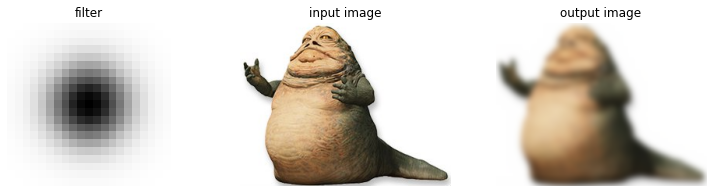

In [6]:
import numpy as np
from tensorflow.keras.layers import Conv2D
from PIL import Image
import matplotlib.pyplot as plt

def gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size - 1)/2, (size - 1)/2, size)
    gauss = np.exp(-0.5 * ax**2 / sigma**2)
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

!wget -q http://www.generalized.ru/assets/jabba.png
input_image = np.array(Image.open('jabba.png'), dtype=float)
kernel_size = 21
kernel = gaussian_kernel(kernel_size, sigma=4)

conv = Conv2D(filters=3, kernel_size=kernel_size, padding='same', use_bias=False)
conv.build((1, *input_image.shape))
layer_weights = np.zeros((21, 21, 3, 3))
for i in range(3): layer_weights[:, :, i, i] = kernel
conv.set_weights([layer_weights])

#using "255 - x" because padding should be white, not black
output_image = 255 - conv(255 - input_image[None, :])[0].numpy()

fig, axes = plt.subplots(1, 3, figsize=(13, 3))
axes[0].imshow(kernel, cmap='Greys')
axes[1].imshow(input_image.astype(np.uint8))
axes[2].imshow(output_image.astype(np.uint8))
for i in range(3): axes[i].axis('off')
axes[0].set_title('filter')
axes[1].set_title('input image')
axes[2].set_title('output image')
plt.show()

Большие изменения в отдельных пикселях входного изображения приводят к небольшим изменениям в результате свертки, поэтому задача обращения гауссова размытия является плохо обусловленной.

Таким образом, в задаче обращения свертки решение часто **не единственно**, а также **может быть неустойчивым**. Задача может и не иметь решения, однако если мы знаем, что исходные данные получены операцией свертки, тогда решение точно существует.

### Методы решения задачи

Все перечисленные ниже способы мы рассмотрим на практике в следующем разделе.

#### Аналитическое решение

Операцию сверки можно представить в виде матрицы. Пусть количество входных каналов равно $C$, а количество фильтров (выходных каналов) равно $F$. Рассмотрим два случая:

- $C = F$. Если мы используем padding, то размер входных данных равен размеру выходных данных, и матрица является квадратной. Она однако может быть вырождена или плохо обусловлена (определитель близок к нулю). В этом случае обратная матрица либо не существует, либо будет расчитана с большой погрешностью.

- $C \ne F$. Матрица свертки получается прямоугольная, и для нее не существует обратной матрицы. Однако может быть рассчитана псевдообратная матрица (generalized inverse matrix, или pseudoinverse matrix). Если $C > F$, то много информации теряется, и восстановить исходные данные можно лишь очень приблизительно и ненадежно. Если $C < F$, то система уравнений получается переопределенной, и как правило решение находится легко.

#### Решение итерационными методами

Задачу поиска $x$ по $f(x)$ можно рассматривать как задачу оптимизации. Поскольку свертка дифференцируема, можно использовать итерационные методы оптимизации, основанные на расчете первых или вторых производных, например, градиентный спуск или L-BFGS.

Исходными данными являются $f$ (веса свертки) и $f(x)$ (результат свертки). Мы ищем $x$, выбирая некое начальное приближение $\hat{x}$ (нулевой или случайный массив) и постепенно корректируя его. В качестве функции потерь можно выбрать среднеквадратичное отклонение между $f(\hat{x})$ и $f(x)$.

У такого способа есть два преимущества:

1. Его можно применять не только к операции свертки, но и ко всему сверточному слою, включая нелинейность ReLU, и даже к сети из многих слоев. На этом основана, например, программа [DeepDream](https://www3.cs.stonybrook.edu/~cse352/T12talk.pdf).

2. Можно с легкостью применять любые способы регуляризации. Регуляризация означает наложение на алгоритм неких (строгих или нестрогих) ограничений с целью получить правдоподобное решение. Подробнее об этом я писал в статье [No-Free-Lunch теорема и важность априорных гипотез в машинном обучении]($No-Free-Lunch теорема и важность априорных гипотез в машинном обучении$).

Что означает понятие *правдоподобное решение*? Посмотрим еще раз на иллюстрацию выше, схема "without padding". Допустим, все веса равны 1 и $y=0$. Одним из возможных является решение $x_1=0, x_2=0, x_3=0$. Но также возможно решение $x_1=1000, x_2=-1000, x_3=0$. Мы предполагаем, что наиболее правдоподобными являются решения с небольшими по модулю элементами. Поэтому мы вводим дополнительную функцию потерь, равную арифметическому среднему квадратов всех элементов $x$ - это называется L2-регуляризацией. В ходе оптимизации мы минимизируем *средневзвешенное между основной функцией потерь (среднеквадратичым отклонением) и функцией L2-регуляризации:*

$\cfrac{1}{hwc} \bigg( \sum\limits_{h, w, c} (f(\hat{x})_{h, w, c} - f(x)_{h, w, c})^2 + \sum\limits_{h, w, c} |\hat{x}_{h, w, c}|^2 \bigg)$.

Могут быть и другие способы регуляризации, в зависимости от наших гипотез о предполагаемых свойствах решения.

#### Решение с помощью транспонированной свертки

Выше мы установили, что свертку для фиксированного размера входных данных можно представить как умножение на матрицу: $f(x) = Ax$ (см. раздел "Свертка как матричное умножение"). Операция транспонированной свертки - это умножение на транспонированную матрицу: $\hat{x} = A^Tf(x)$. Геометрическую иллюстрацию транспонированной свертки можно найти в статье [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285).

Обычная свертка $A$ связывает некоторые элементы входного массива с некоторыми элементами выходного массива с помощью весов, и поэтому ее можно представить как набор троек: *(координаты входного элемента; координаты выходного элемента; вес)*. Каждая такая тройка означает ячейку в матрице $A$. Транспонированная свертка $A^T$ использует те же веса, действующие "в обратном направлении", то есть тот же набор троек, в котором меняются местами входной и выходной элемент.

Это логично с той точки зрения, что в сверточных нейронных сетях каждый элемент входного и выходного массивов представляет собой какой-то признак, и если между ними есть прямая связь, то должна иметь место и точно такая же обратная связь. Но действительно ли $A^TAx$ близко к $x$? На самом деле нет. В общем случае используя одни и те же веса сначала в прямом, а затем в обратном направлении, мы можем получить результат сильно непохожий на исходные данные.

<img src="assets/timemachine.jpg" width="500" align="center">

([источник картинки](https://pikabu.ru/story/kogda_ne_do_kontsa_razobralsya_v_mekhanike_4578946))

Транспонированная матрица равна обратной только в том случае, если матрица $A$ ортогональна. Чем ближе матрица $A$ к ортогональной, тем точнее $A^T$ приближает $A^{-1}$. Поэтому используя транспонированную свертку с теми же весами для обратного преобразования мы надеемся, что свертка близка к ортогональному преобразованию. Так это или нет - мы проверим в разделе, посвященном экспериментам.

Аналогичный способ используется и в некоторых полносвязных автокодировщиках: слой сети работает в прямом направлении с помощью матрицы $A$ и в обратном направлении с помощью матрицы $A^T$. Неортогональная матрица даст при восстановлении входных данных высокий loss, близкая к ортогональной - низкий loss, поэтому в ходе минимизации loss матрица постепенно приближается к ортогональной.

*Примечание. В Keras для транспонированной свертки используется слой `Conv2DTranspose`. Однако транспонированную свертку с параметром strides = 1 можно представить в виде обычной свертки, а транспонированную свертку с параметром strides > 1 можно представить как композицию операции upsampling, при которой элементы исходного массива чередуются с нулевыми элементами, и обычной свертки. Но слой `Conv2DTranspose` выполняет транспонировоанную свертку более эффективно с точки зрения количества вычислений и расхода памяти, чем композиция из  upsampling и Conv2D.*

### Эксперименты

В этом разделе мы релизуем перечисленные методы в коде и проверим, насколько хорошо они могут решать поставленную задачу.

#### Фреймворк

Будем использовать библиотеки TensorFlow и Keras. Наиболее лаконичным вариантом кода будет наследоваться от класса `keras.layers.Conv2D`, добавив в него метод `reverse`. Из этого обобщенного метода будем вызывать конкретные его реализации.

In [65]:
from tensorflow.keras.layers import Conv2D

class ReversableConv2D(Conv2D):
  def reverse(self, output, method, input_shape=None,
              timing=False, verbose=0, **kwargs):
    input_shape = input_shape or self.input_shape
    input_shape = [len(output)] + list(input_shape[1:]) #setting batch_size
    func = globals()['reverse_by_' + method]
    start_time = time.time()
    result = func(self, output, input_shape, verbose=verbose, **kwargs).numpy()
    elapsed_time = time.time() - start_time
    if timing:
      if verbose: print(f"Method '{method}' took {elapsed_time:g} seconds")
      return result, elapsed_time
    else:
      return result

Теперь реализуем четыре метода обратного преобразования: с помощью Adam, L-BFGS, транспонированной и псведообратной матрицы.

In [61]:
!pip install tensorflow_probability -q

from tensorflow import keras
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import mse
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import time

def reverse_by_adam(conv_layer, output, input_shape,
                    start_lr=1e-1, end_lr=1e-3, max_iterations=2000,
                    verbose=0, l2=0, **kwargs):
  # using output and conv_layer, trying to optimize input
  input = tf.Variable(tf.random.uniform(input_shape, 0, 1), trainable=True)
  optimizer = Adam(ExponentialDecay(start_lr, max_iterations, end_lr/start_lr))
  @tf.function
  def train_step(): #defining optimization step
    with tf.GradientTape() as tape:
      loss = tf.math.reduce_mean(mse(output, conv_layer(input)))
      loss += l2 * tf.math.reduce_mean(input**2) #L2 regularization
    grads = tape.gradient(loss, input)
    optimizer.apply_gradients(((grads, input),))
    return loss
  losses = []
  for step in range(max_iterations):
    losses.append(train_step().numpy()) #making optimization step
    # early stopping:
    if losses[-1] < 1e-8 \
        or (len(losses) > 100 and losses[-100] < np.min(losses[-99:])):
      if verbose==1: print('Break at step', step)
      break
  return input

def reverse_by_lbfgs(conv_layer, output, input_shape,
                     max_iterations=2000, l2=0, verbose=0, **kwargs):
  input_shape_flat = (np.prod(input_shape),)
  @tf.function
  def step(input):
      input = tf.reshape(input, input_shape)
      loss = tf.math.reduce_mean(mse(output, conv_layer(input)))
      loss += l2 * tf.math.reduce_mean(input**2)
      gradients = tf.gradients(loss, input)[0]
      return loss, tf.reshape(gradients, input_shape_flat)
  input = tf.random.uniform(input_shape_flat, 0, 1)
  result = tfp.optimizer.lbfgs_minimize(step, initial_position=input,
      num_correction_pairs=10, tolerance=1e-8, max_iterations=max_iterations)
  if verbose: print('converged:', result.converged.numpy())
  return tf.reshape(result.position, input_shape)

def reverse_by_transpose(conv_layer, output, input_shape, **kwargs):
  input_channels = input_shape[3] if conv_layer.data_format=='channels_last' \
        else input_shape[1]
  reverse_layer = Conv2DTranspose(input_channels, conv_layer.kernel_size,
        strides=conv_layer.strides, padding=conv_layer.padding,
        data_format=conv_layer.data_format, use_bias=False)
  reverse_layer.build(output.shape)
  reverse_layer.set_weights(conv_layer.get_weights())
  return reverse_layer(output)

def get_convolution_matrix(conv_layer, input_shape, output_shape):
  assert len(input_shape) == 4 and input_shape[0] == 1 #batch size should be 1
  assert conv_layer.data_format == 'channels_last'
  input_shape_flat = np.prod(input_shape)
  output_shape_flat = np.prod(output_shape)
  conv_matrix = np.zeros((output_shape_flat, input_shape_flat))
  kernel = conv_layer.get_weights()[0]
  kernel_size_h, kernel_size_w = kernel.shape[0], kernel.shape[1]
  for h in range(output_shape[1]):
    for w in range(output_shape[2]):
      for f in range(output_shape[3]):
        # (h, w, f) - index of output element
        output_flat_index = np.ravel_multi_index((0, h, w, f), output_shape)
        for dh in range(-(kernel_size_h//2), (kernel_size_h+1)//2):
          for dw in range(-(kernel_size_w//2), (kernel_size_h+1)//2):
            for c in range(input_shape[3]):
              # (dh, dw, c) - index of weight in convolution kernel
              if conv_layer.padding == 'valid':
                input_h = h + kernel_size_h//2 + dh
                input_w = w + kernel_size_w//2 + dw
              else:
                input_h = h + dh
                input_w = w + dw
                if input_h < 0 or input_h >= input_shape[1]: continue
                if input_w < 0 or input_w >= input_shape[2]: continue
              # (input_h, input_w, c) - index of output element
              input_flat_index = np.ravel_multi_index((0, input_h, input_w, c),
                                                      input_shape)
              weight = kernel[dh+kernel_size_h//2, dw+kernel_size_w//2, c, f]
              conv_matrix[output_flat_index, input_flat_index] = weight
  return conv_matrix

def reverse_by_pseudoinverse(conv_layer, output, input_shape, verbose=0, **kwargs):
  start_time = time.time()
  conv_matrix = get_convolution_matrix(conv_layer, input_shape, output.shape)
  if verbose: print(f'Conv matrix built in {time.time() - start_time:.2f} s')
  start_time = time.time()
  deconv_matrix = np.linalg.pinv(conv_matrix)
  if verbose: print(f'Deconv matrix built in {time.time() - start_time:.2f} s')
  result_flat = deconv_matrix @ output.reshape(-1)
  result = result_flat.reshape(input_shape)
  return tf.constant(result)

Оценивать качество $\hat{x}$ будем следующим образом. Будем предсказывать $x$ по $\hat{x}$ с помощью линейной регрессии и определять коэффициент детерминации $R^2$. Как мы увидим далее, транспонированная свертка может восстанавливать $\hat{x}$ с хорошей точностью, но в другом масштабе, и линейная регрессия может исправить эту проблему. Кроме того при оценке качества мы будем игнорировать элементы массива, находящиеся у самого края, потому что они восстанавливаются с существенно большей погрешностью.

In [89]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def plot(input, restored_input, features=None, format='channels_last'):
  data = {'Input': input, 'Restored input': restored_input,
          'Difference': (restored_input - input)}
  if features is not None:
    data['Features'] = features
  fig, axes = plt.subplots(1, len(data), figsize=(15, 4))
  for ax, (title, array) in zip(axes, data.items()):
    if format=='channels_first':
      array = np.moveaxis(array, 1, 3)
    if array.shape[3] == 1: #black and white
      array = array[..., 0]
    ax.imshow(array[0])
    ax.set_title(title)
    ax.axis('off')
  plt.show()

def measure_quality(input, restored_input, pad=3, print_coefs=False):
  X = input[:, pad:-pad, pad:-pad, :].reshape(-1, 1)
  y = restored_input[:, pad:-pad, pad:-pad, :].reshape(-1)
  reg = LinearRegression().fit(X, y)
  if print_coefs: print('scale:', reg.coef_[0], '\nbias:', reg.intercept_)
  return reg.score(X, y)

def plot_quality(input, restored_input, pad=3, ax=None, title='', **kwargs):
  if ax is None:
    fig = plt.figure(figsize=(5, 3))
    ax = plt.gca()
  X = input[:, pad:-pad, pad:-pad, :].reshape(-1)
  y = restored_input[:, pad:-pad, pad:-pad, :].reshape(-1)
  plt.scatter(X, y, s=500/np.sqrt(len(X)))
  ax.set_xlabel('Input')
  ax.set_ylabel('Restored input')
  q = measure_quality(input, restored_input, pad=pad, **kwargs)
  ax.set_title(f'{title} quality: {q}')
  plt.show()

#### Выводы из экспериментов

Далее я буду перечислять сделанные выводы, снабжая каждый вывод кодом для воспроизведения результатов.

**Скорость работы**

Расчет псевдообратной матрицы занимает очень много времени, и имеет сложность примерно O(n^3) относительно размеров входного и выходного массивов. Это делает невозможным его применение в случае большого количества входных каналов и фильтров.

В таблице показано время в секундах работы для разных методов, с размером входного тензора $(32, 32, C)$ и $C$ фильтрами.

In [ ]:
methods = ['transpose', 'adam', 'lbfgs', 'pseudoinverse']
for C in [1, 2, 4, 8]:
  print(C)
  conv = ReversableConv2D(C, 5, padding='valid', use_bias=False)
  input_shape = (1, 32, 32, C)
  input = np.random.rand(*input_shape)
  features = conv(input).numpy()
  for method in methods:
    restored, _ = conv.reverse(features, method=method,
                            input_shape=input_shape, timing=True, verbose=True)
    print(measure_quality(input, restored))

| Method | C=1 | C=2 | C=4 | C=8 | C=16 |
| --- | --- | --- | --- | --- | --- |
| adam | 0.2 | 0.3 | 1.0 | 0.6 | 0.9 |
| L-BFGS | 1.7 | 3.5 | 4.2 | 4.4 | 4.3 |
| transpose | 0.007 | 0.003 | 0.003 | 0.003 | 0.003 |
| pseudoinverse | 0.5 | 3.4 | 26.2 | 220 | 0.0 |

**Оптимальная величина L2-регуляризации**

Метод L-BFGS хорошо работает без L2-регуляризации, тогда как Adam для оптимального качества требует коэффициент L2-регуляризации порядка $2*10^{-4}$. Впрочем возможно, что эта величина зависит от многих параметров. Чрезмерная L2-регуляризация вызывает сильное падение качества.

На графике ниже показана зависимость качества работы методов ($R^2$ score) от величины L2-регуляризации для задачи преобразования массива 32x32x32 в массив 30x30x32 сверткой 3x3 c `padding='valid'` (этот параметр в Keras означает отсутствие padding).

In [ ]:
results = {'adam': [], 'lbfgs': []}
l2_values = np.logspace(-5, -2, num=50)
for l2 in l2_values:
  conv = ReversableConv2D(32, 3, padding='valid', use_bias=False)
  input_shape = (1, 32, 32, 32)
  input = np.random.rand(*input_shape)
  features = conv(input).numpy()
  for method in ['adam', 'lbfgs']:
    restored = conv.reverse(features, method=method,
                              input_shape=input_shape, l2=l2)
    quality = measure_quality(input, restored)
    print('Method:', method, 'L2:', l2, 'Quality:', quality)
    results[method].append(quality)

for method in ['adam', 'lbfgs']:
  plt.scatter(l2_values, results[method], label=method)
plt.legend()
plt.gca().set_xscale('log')
plt.gca().set_ylim(0.85, 0.95)
plt.gca().set_xlabel('L2 reg')
plt.gca().set_ylabel('R2 score')
plt.show()

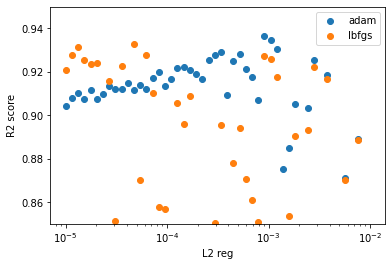

**Сравнение качества**

Надежная оценка не так проста: результаты могут сильно зависеть от количества каналов, фильтров и от конкретного вида фильтров.

Сначала попробуем использовать **случайно инициализированные фильтры** методом выборки чисел из равномерного распределения (метод *Glorot uniform*). Именно так фильтры инициализируются по умолчанию в Keras. Ниже показана метрика качества и время работы всех алгоритмов, для разного количества каналов (*input channels*) и фильтров (*output channels*). Использовались изображения 32x32, `padding='valid'`, видеокарта Tesla P100. Для метода *pseudoinverse* не получилось рассчитать все результаты из-за большой длительности этого метода.

In [ ]:
from tqdm.notebook import tqdm
import time

def estimate_reverse_ops(get_conv_and_input_fn):
  methods = ['transpose', 'lbfgs', 'adam', 'pseudoinverse']
  fig, axes = plt.subplots(2, len(methods), figsize=(15, 9), squeeze=False)

  for method_idx, method in enumerate(methods):
    print(method + '...')
    channels_range = [1, 2, 4, 8, 16, 32, 64]
    quality = np.zeros((len(channels_range), len(channels_range)))
    elapsed_times = np.zeros((len(channels_range), len(channels_range)))

    for i, n_input_channels in enumerate(tqdm(channels_range, leave=False)):
      for j, n_output_channels in enumerate(tqdm(channels_range, leave=False)):
        if method=='pseudoinverse' and n_input_channels*n_output_channels > 16:
          # expected to take too long time
          elapsed_times[i][j] = np.nan
          quality[i][j] = np.nan
          continue
        conv, input = get_conv_and_input_fn(n_input_channels, n_output_channels)
        features = conv(input).numpy()
        l2 = dict(adam=2e-4, lbfgs=0, transpose=0, pseudoinverse=0)[method]
        restored, elapsed_time = conv.reverse(features, method=method,
                                input_shape=input.shape, l2=l2, timing=True)
        elapsed_times[i][j] = elapsed_time
        quality[i][j] = measure_quality(input, restored)
    for row in [0, 1]:
      ax = axes[row, method_idx]
      array = quality if  row == 0 else elapsed_times
      values_range = (0, 1) if  row == 0 else (0, 8)
      title = 'quality' if row == 0 else 'elapsed time'
      ax.set_title(method + ' ' + title)
      ax.imshow(array, vmin=values_range[0], vmax=values_range[1])
      ax.set_xticks(np.arange(len(channels_range)))
      ax.set_yticks(np.arange(len(channels_range)))
      ax.set_xticklabels(channels_range)
      ax.set_yticklabels(channels_range)
      ax.set_xlabel('n_input_channels')
      ax.set_ylabel('n_output_channels')
      for (j, i), label in np.ndenumerate(array):
        ax.text(i, j, f'{label:.2f}', ha='center', va='center')
        ax.text(i, j, f'{label:.2f}', ha='center', va='center')

  plt.show()

def get_conv_and_input_fn(n_input_channels, n_output_channels):
  conv = ReversableConv2D(n_output_channels, kernel_size=3,
                          padding='valid', use_bias=False)
  input_shape = (1, 32, 32, n_input_channels)
  input = np.random.rand(*input_shape)
  return conv, input

estimate_reverse_ops(get_conv_and_input_fn)

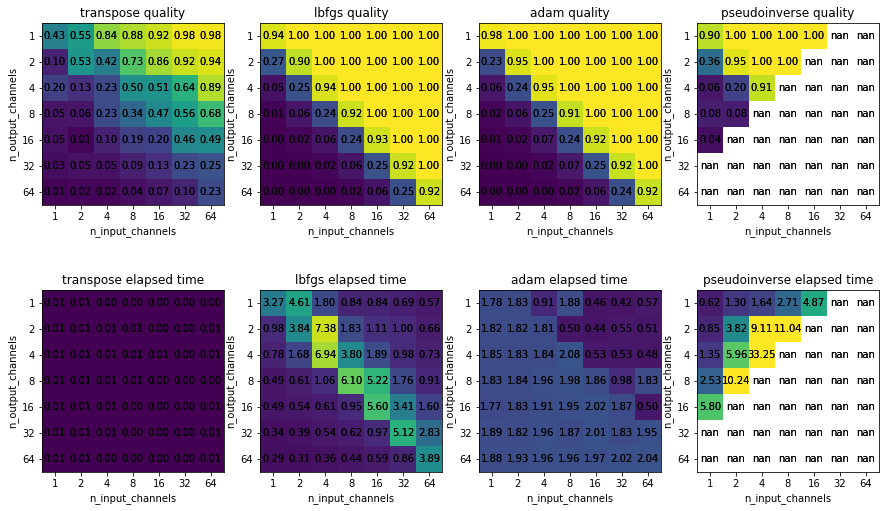

Как видим, транспонирование существенно проигрывает в качестве по сравнению с остальными методами, но в случае, когда фильтров намного больше, чем каналов, все же позволяет с хорошей точностью восстановить входные данные.

Еще одной проблемой транспонирования является то, что ответ дается в другом масштабе. На графике ниже видно, что $\hat{x}$ соотносится с $x$ приблизительно по формуле $\hat{x} \approx 1.9x - 0.1$

scale: 1.9146371364376866 
bias: -0.12182400033798257


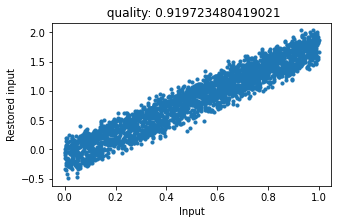

In [90]:
conv = ReversableConv2D(128, 3, padding='same', use_bias=False)
input_shape = (1, 32, 32, 4)
input = np.random.rand(*input_shape)
features = conv(input).numpy()
result = conv.reverse(features, method='transpose', input_shape=input_shape)
plot_quality(input, result, print_coefs=True)

Метод псевдообратной матрицы работает намного дольше Adam и L-BFGS, но дает схожие по качеству результаты.

Интересно посмотреть на то, как выглядит псевдообратная матрица. Ниже показан один и тот же участок на матрице свертки $A$ и псевдообратной матрице $A^+$ (1 входной канал, 1 случайный фильтр 5x5). Вся матрица имеет размер примерно в 10 раз больший по горизонтали и вертикали. Вид матрицы говорит о том, что обратные связи в ней соединяют те элементы, между которыми вообще не было прямой взаимосвязи в матрице $A$, что странно. Возможно это артефакт вычислений с плавающей запятой из-за плохой обусловленности задачи.

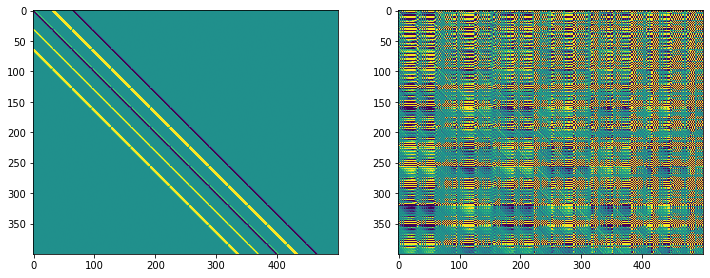

In [109]:
def draw_deconv_matrix(input_channels, output_channels, kernel_size, padding):
  conv = ReversableConv2D(filters=output_channels, kernel_size=kernel_size,
                            padding=padding, use_bias=False)
  input_shape = (1, 32, 32, input_channels)
  conv.build(input_shape)
  input = np.random.rand(*input_shape)
  output = conv(input).numpy()
  conv_matrix = get_convolution_matrix(conv, input.shape, output.shape)
  deconv_matrix = np.linalg.pinv(conv_matrix)

  fit, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
  ax1.imshow(conv_matrix[:400, :500], vmin=-0.1, vmax=0.1)
  ax2.imshow(deconv_matrix[:400, :500], vmin=-0.5, vmax=0.5)
  plt.show()

draw_deconv_matrix(input_channels=1, output_channels=1, kernel_size=5, padding='same')

Если количество входных каналов сильно больше или сильно меньше количества фильтров, то псевдообратная матрица имеет такой же "ступенчатый" вид, как и матрица свертки. Артефакты появляются в матрице тогда, когда количество входных каналов примерно равно количеству фильтров.

TODO гауссово размытие, веса VGG